In [3]:
import pandas as pd

import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import sys
from loguru import logger
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import layers
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.python.keras.layers import Dense, Flatten, Input, Dropout
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.callbacks import EarlyStopping, TensorBoard

import keras_tuner as kt
from keras_tuner.tuners import RandomSearch, Hyperband
from keras_tuner.engine.hyperparameters import HyperParameters as hp
from tensorflow.keras.models import Sequential

sys.path.append('..')

from definitions import get_project_root
from src.data.make_dataset import create_train_test_validation
from src.visualization.visualize import plot_results
from src.models.train_model import simple_baseline, get_randomforest_score

root = get_project_root()


c:\Users\huube\OneDrive\Master of Informatics\Machine Learning\Eindopdracht\.venv\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.5.0 and strictly below 2.8.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(
2022-02-13 20:50:52.921 | INFO     | src.data.make_dataset:create_train_test_validation:73 - found file labeled_data.csv, procceed with creating train, test and validation sets


<h2> We will analyse and discuss the results



In [5]:
scores = {}

In [4]:
# Step 1 is loading in the data.
x_train, x_valid, x_test, y_train, y_valid, y_test = create_train_test_validation()
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape, x_test.shape, y_test.shape

2022-02-13 20:51:02.168 | INFO     | src.data.make_dataset:create_train_test_validation:73 - found file labeled_data.csv, procceed with creating train, test and validation sets


((61711, 23), (61711, 1), (13225, 23), (13225, 1), (13224, 23), (13224, 1))

In [12]:
## We will also load in our simple/naive model
scores['simple_baseline'] = simple_baseline()

In [13]:
## Load in the randomforest scores
scores['randomforest'] = get_randomforest_score()

..\src\models\train_model.py:55: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_clf.fit(x_train, y_train)


In [6]:
## Let's load in the first NN model
model_file = root / 'src' / 'models' / 'best_base_model.model'
best_base_model = tf.keras.models.load_model(model_file)

scores['best_base_model'] = best_base_model.evaluate(x_train,y_train)

1929/1929 [==============================] - 2s 846us/step - loss: 1.2867 - accuracy: 0.5735


In [15]:
## Let's import the winning hypermodel.
model_file = root / 'src' / 'models' / 'winning_hypermodel.model'
winning_hyper_model = tf.keras.models.load_model(model_file)

scores['hyperNN'] = winning_hyper_model.evaluate(x_test,y_test)

414/414 [==============================] - 1s 980us/step - loss: 1.3500 - accuracy: 0.5537


In [17]:
scores

{'simple_baseline': 0.3842256503327284,
 'randomforest': 0.5569419237749547,
 'best_base_model': [1.286680817604065, 0.5734795928001404],
 'hyperNN': [1.3500087261199951, 0.5536902546882629]}

<AxesSubplot:xlabel='Model', ylabel='accuracy'>

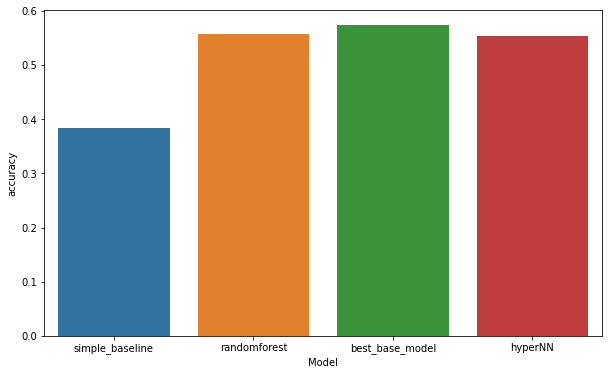

In [16]:
## Let's display the scores in a barplot
df_plot = pd.DataFrame(scores)
df_plot = df_plot.unstack().reset_index()
df_plot = df_plot[df_plot['level_1']==1]
df_plot.drop(columns=['level_1'],inplace=True)
df_plot.columns=['Model','accuracy']

plt.figure(figsize=(10,6))
sns.barplot(data=df_plot,x="Model",y="accuracy")

Let's examine a confusion matrix


In [9]:
## But first we need to find our labels again
data_file = root / "src" / "data" / "processed" / "labeled_data.csv"
df_labeled = pd.read_csv(data_file)
df_labeled['genre']

labels = []
oe = OrdinalEncoder()
encoded = oe.fit_transform(df_labeled["genre"].to_numpy().reshape(-1, 1))
for i,val in enumerate(oe.categories_[0]):
    labels.append(val)

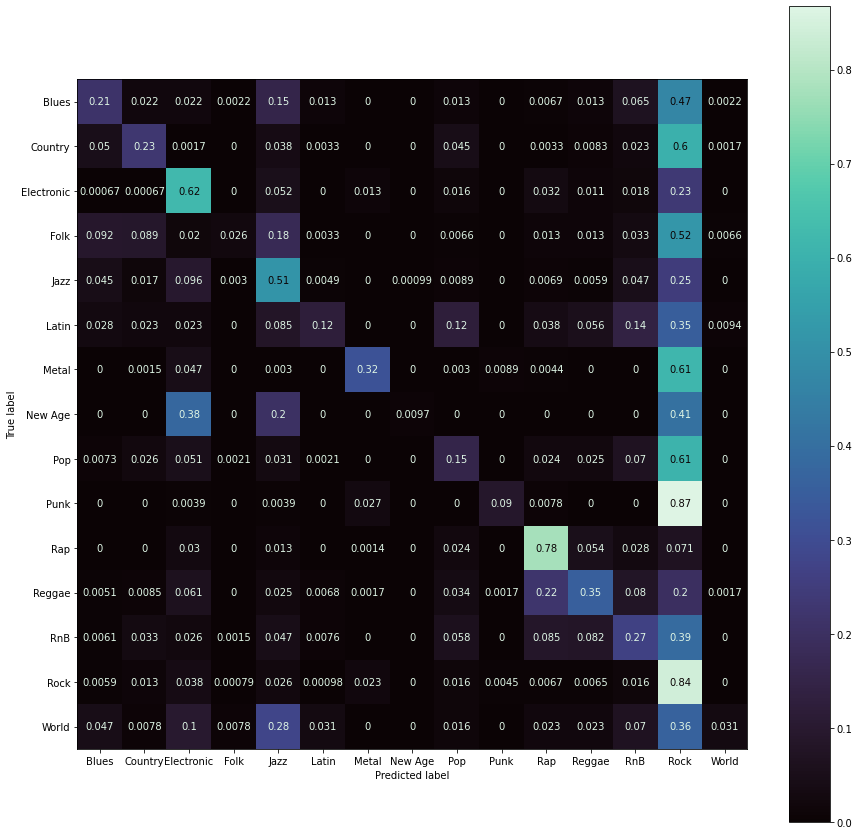

In [66]:
## Build the confusion matrix
y_pred = winning_hyper_model.predict(x_test).argmax(axis=1)

fig, ax = plt.subplots(figsize=(15,15))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred,ax=ax,normalize='true',display_labels=labels,cmap="mako")

<h2> Conclusions </h2>

So at this point, the base model (neural network) wins with a accuracy of 57.3%

When we look at the confusion matrix, we see that there often is a wrong classification and that the rock genre is often the predicted value. Rock does get a true postive score of 84% procent but it also becomes quit clear that some neighbouring genres like metal and punk are also more often classified as rock then as their correct genre. Overall this coould mean that the class imbalance in the dataset is creating a disbalance which impact the models in a negative way. 

<h3>What could we do to improve? </h3>
A possible countermeasure would be to try to increase the dataset and have equal sample sizes per genre.
Another angle of improving possibilities would be adding more / other data related to the songs. We could perform a sentiment and/or text analysis on lyrics and add it. We could maybe try to collect more data like what instruments are in the song. Or one step further could be to analyize the audio data itself. 

But for now unfortunately this model is not good enough to use since Electronic, Jazz, Rap and Rock are the only genres that can be predicted with a higher true postive score than 50%. So also because of the earlier mentioned class imbalance, the accuracy score of 55.7 is very inflated by the absolute number of Rock songs in the dataset.

Even though the end result might not be satisfying by itself, I do have to mention that I've learned a lot when working on this assignment. Most importantly: I've learned that there is still a lot to learn! 

